In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from sklearn.cross_validation import train_test_split
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_data']
    train_labels = save['train_labels']
    test_dataset = save['test_data']
    test_labels = save['test_labels']
    test_filenames = save['test_filenames']
    valid_dataset = save['valid_data']
    valid_labels = save['valid_labels']
    del save
    
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (73401, 32, 32, 1) (73401, 6)
Validation set (10000, 32, 32, 1) (10000, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [3]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in xrange(0, kernel_shape[2]):
        for i in xrange(0, kernel_shape[0]):
            for j in xrange(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

In [4]:
def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [5]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X
    return new_X

In [6]:
def accuracy(predictions, labels, printstat=False):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [7]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

batch_size = 64
patch_size = 5
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 64
shape = [batch_size, image_size, image_size, num_channels]

# Construct a 7-layer CNN.
# C1: convolutional layer, batch_size x 32 x 32 x 16, convolution size: 5 x 5 x 1 x 16
# P2: pooling layer, batch_size x 14 x 14 x 16
# C3: convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# P4: pooling layer, batch_size x 5 x 5 x 32
# C5: convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# F6: fully-connected layer, weight size: 64 x 11
# Output layer, weight size: 16 x 10

graph = tf.Graph()

with graph.as_default():

    # Input data placeholders.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')

    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')        
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        
        return [logits1, logits2, logits3, logits4, logits5]

    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)
    loss =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.1, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation and test data.
    train_logits = model(tf_train_dataset, 1.0, shape)
    train_prediction = tf.pack([tf.nn.softmax(train_logits[0]), tf.nn.softmax(train_logits[1]),\
                                tf.nn.softmax(train_logits[2]), tf.nn.softmax(train_logits[3]),\
                                tf.nn.softmax(train_logits[4])])
    
    valid_logits = model(tf_valid_dataset, 1.0, shape)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]), tf.nn.softmax(valid_logits[1]),\
                                tf.nn.softmax(valid_logits[2]), tf.nn.softmax(valid_logits[3]),\
                                tf.nn.softmax(valid_logits[4])])
    
    test_logits = model(tf_test_dataset, 1.0, shape)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]), tf.nn.softmax(test_logits[1]),\
                               tf.nn.softmax(test_logits[2]), tf.nn.softmax(test_logits[3]),\
                               tf.nn.softmax(test_logits[4])])

    saver = tf.train.Saver()

In [8]:
num_steps = 10001
loss_values = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()  
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
        if step % 10 == 0:
            loss_values.append(l)
            
        if (step % 1000 == 0): 
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))    
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,1:6]))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
    
    save_path = saver.save(session, "cnn.convnet")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 11.997540
Minibatch accuracy: 12.8%
Validation accuracy: 53.7%
Minibatch loss at step 1000: 6.140862
Minibatch accuracy: 58.4%
Validation accuracy: 56.3%
Minibatch loss at step 2000: 5.396994
Minibatch accuracy: 63.1%
Validation accuracy: 65.6%
Minibatch loss at step 3000: 3.039668
Minibatch accuracy: 81.6%
Validation accuracy: 79.9%
Minibatch loss at step 4000: 2.749557
Minibatch accuracy: 85.0%
Validation accuracy: 83.3%
Minibatch loss at step 5000: 2.115998
Minibatch accuracy: 87.8%
Validation accuracy: 85.3%
Minibatch loss at step 6000: 2.868312
Minibatch accuracy: 84.7%
Validation accuracy: 86.2%
Minibatch loss at step 7000: 2.173912
Minibatch accuracy: 87.8%
Validation accuracy: 87.2%
Minibatch loss at step 8000: 2.533219
Minibatch accuracy: 86.9%
Validation accuracy: 88.1%
Minibatch loss at step 9000: 2.044842
Minibatch accuracy: 90.0%
Validation accuracy: 88.5%
Minibatch loss at step 10000: 2.204009
Minibatch accuracy: 87.5%
Validation accu

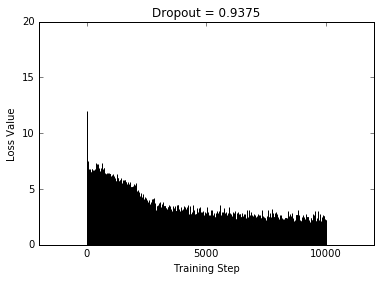

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)

plt.bar(np.arange(0,10001,10), loss_values, align='center')
plt.title('Dropout = 0.9375')
plt.xlabel('Training Step')
plt.yticks(np.arange(0,21,5))
plt.xticks(np.arange(0,10500,5000))
plt.ylabel('Loss Value')

plt.show()

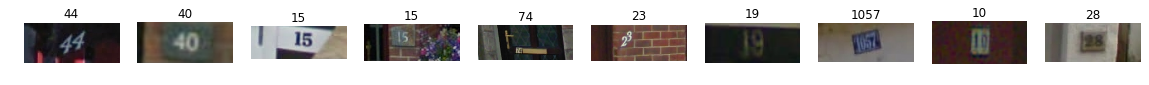

In [18]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
for i, item in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = test_filenames[item]
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[item,0]):
        house_num += str(test_labels[item,k+1])
        
    im_samples.extend([item])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [19]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_test_dataset = tf.placeholder(tf.float32, shape=(10, 32, 32, 1))

    # Variables.
    layer1_weights = tf.get_variable("W1", shape=[patch_size, patch_size, num_channels, depth1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
    layer2_weights = tf.get_variable("W2", shape=[patch_size, patch_size, depth1, depth2],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2')
    layer3_weights = tf.get_variable("W3", shape=[patch_size, patch_size, depth2, num_hidden1],\
           initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='B3')

    s1_w = tf.get_variable("WS1", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[num_hidden1, num_labels],\
           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
  
    # Model.
    def model(data, keep_prob, shape):
        LCN = LecunLCN(data, shape)
        conv = tf.nn.conv2d(LCN, layer1_weights, [1,1,1,1], 'VALID', name='C1')
        hidden = tf.nn.relu(conv + layer1_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
        conv = tf.nn.conv2d(sub, layer2_weights, [1,1,1,1], padding='VALID', name='C3')
        hidden = tf.nn.relu(conv + layer2_biases)
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S4')
        conv = tf.nn.conv2d(sub, layer3_weights, [1,1,1,1], padding='VALID', name='C5')
        hidden = tf.nn.relu(conv + layer3_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        logits1 = tf.matmul(reshape, s1_w) + s1_b
        logits2 = tf.matmul(reshape, s2_w) + s2_b
        logits3 = tf.matmul(reshape, s3_w) + s3_b
        logits4 = tf.matmul(reshape, s4_w) + s4_b
        logits5 = tf.matmul(reshape, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
  
    # Training computation.
    [logits1, logits2, logits3, logits4, logits5] = model(tf_test_dataset, 1, [10, 32, 32, 1])

    predict = tf.pack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),tf.nn.softmax(logits3),\
                       tf.nn.softmax(logits4),tf.nn.softmax(logits5)])
    test_prediction = tf.transpose(tf.argmax(predict, 2))
    saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
    saver.restore(session, "cnn.convnet")
    print("Model restored.")  

    print('Initialized')
    test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
    print(test_prediction)

Model restored.
Initialized
[[ 4  4 10 10 10]
 [ 4  0 10 10 10]
 [ 1  5 10 10 10]
 [ 1  5  5 10 10]
 [ 2  4 10 10 10]
 [ 1 10 10 10 10]
 [ 1  4  4 10 10]
 [ 1  5  5 10 10]
 [ 1  0 10 10 10]
 [ 2  8 10 10 10]]


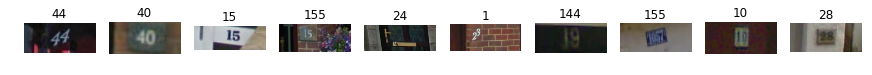

In [20]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = test_filenames[j]
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)):
        house_num += str(test_prediction[i,k])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)